# Lab 5: Sentiment Analysis with fine-tuned Transformers

In this lab session, you will fine-tune a **Transformer** based pre-trained language model for sentiment analysis. Transfer learning with large pre-trained language models has been shown to be successful strategy to achieve state-of-the-art performances. In this lab we'll learn how to do transfer learning with large pre-trained neural language models like BERT.

More concretely, in this lab session will learn the following:

- Deploy and fine-tune transformers from the [Hugging Face library](https://github.com/huggingface/transformers)
- Preprocessing data for transformers archicture (word piece tokenizatiin)
- Implementation of Transformer-based classifier



----

## Transfer Learning

Figure below shows how to fine-tune a transformer on a downstream task. Here, the fine-tuning task is sentiment analysis of movie reviews. As learned from theory, we will use the knowledge encoded in the Transformer to learn better our target task. So our sentiment classifier has two main components: 1) the text encoder based on BERT (which doesn't know anything about sentiments, but knows something about English), and 2) the component dedicated to sentiment classification (a simple feed-forward layer). In other words, BERT will generate the sentence embeddings of the input and pass to the classifier layer to the prediction. When we fine-tune our classifier we'll change BERT's parameters as well, and make it to learn specific aspects of the task.

 ![](http://ixa2.si.ehu.es/~jibloleo/uc3m_dl4nlp/img/fine-tuning.png)


Advantages of these types of architectures and learning:

- Unlimited amount of unlabelled text data can be scraped from the web with very little effort to train a large language model.
- Transformer is a feed-forward architecture that allows highly parallelized, efficient training on huge datasets, with the objective of simply predicting words based on their context ([check the tutorial on strategy learning for sequence classification](https://colab.research.google.com/drive/1yWaLpCWImXZE2fPV0ZYDdWWI8f52__9A#scrollTo=MGqVkG2-7qfu)).
- Although pre-training a language model can be expensive, fine-tuning can be done in a single GPU most of the times, as tipically it requiere few learning epochs.


## 1. Loading the data
We'll use the same data for sentiement analysis used in previous sessions. So first, we need to mount our Drive account.

In [1]:
# Mount Drive files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# install libraries
!pip install datasets==2.17.1

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# Other imports
import time
import numpy as np
import pandas as pd
import re
from sklearn.utils import shuffle
from datasets import load_dataset
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(2)
np.random.seed(2)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 9.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2023.10.0 which is incompatible.


In [3]:
# device - PyTorch requires explicit device management
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [4]:
from sklearn.utils import shuffle

# custom data loader path CHANGE home TO YOUR DIRECTORY
home = '/content/drive/MyDrive/Colab Notebooks/dl4nlp_summer_labs/'
sst_home = home + 'utils/sst_custom_loader.py'
# load data with load_dataset and our custom data loader script
data = load_dataset(sst_home)
training_set = pd.DataFrame(data['train'])
dev_set = pd.DataFrame(data['validation'])
test_set = pd.DataFrame(data['test'])

# Shuffle dataset
training_set = shuffle(training_set)
dev_set = shuffle(dev_set)
test_set = shuffle(test_set)

# Obtain text and label vectors
train_texts = training_set.text
train_labels = training_set.label

dev_texts = dev_set.text
dev_labels = dev_set.label

test_texts = test_set.text
test_labels = test_set.label

print('Training size: {}'.format(len(training_set)))
print('Dev size: {}'.format(len(dev_set)))
print('Test size: {}'.format(len(test_set)))

/usr/local/lib/python3.12/dist-packages/datasets/load.py:923: FutureWarning: The repository for sst_custom_loader contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at /content/drive/MyDrive/Colab Notebooks/dl4nlp_summer_labs/utils/sst_custom_loader.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Training size: 6920
Dev size: 872
Test size: 1821


## 2. Installing and seting up the Transformers library

In [5]:
# Transformers docs: https://huggingface.co/docs/transformers
!pip install transformers

Once the Transformers library is installed, we typically work with three core components:

- **The tokenizer class**: converts input strings into tensors of integer token ids (indices into the model vocabulary). Tokenization varies by model family, so each model has its own tokenizer.

- **The model class**: contains the neural network itself. In PyTorch, models inherit from `torch.nn.Module` and are used via standard forward calls. You can train them with a regular PyTorch training loop or use the Hugging Face `Trainer` API if preferred.

- **The configuration class**: holds hyperparameters such as number of layers, dropout, etc. Unless you rely entirely on defaults, you can provide a configuration to customize the model. Below is an example of a BERT configuration (for the pre-trained weights `bert-base-cased`).

```
{
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 28996
}
```


In [6]:
from transformers import BertForSequenceClassification, BertTokenizer

model = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2).to(device)
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Next we will define two helper functions: 1) extract features from the tokenizer (`convert_examples_to_features`) and 2) convert the features to a PyTorch `Dataset` (our `convert_features_to_tf_dataset` returns a custom subclass), which we will then wrap in a `DataLoader` for efficient batching and shuffling. See the PyTorch [`DataLoader` docs](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for details.

In [7]:
from transformers import InputFeatures
from torch.utils.data import DataLoader

class TorchDataset(Dataset):
  def __init__(self, features):
    self.features = features

  def __len__(self):
    return len(self.features)

  def __getitem__(self, i):
    ex = self.features[i]
    return {
        "input_ids": torch.tensor(ex.input_ids, dtype=torch.long),
        "attention_mask": torch.tensor(ex.attention_mask, dtype=torch.long),
        "token_type_ids": torch.tensor(ex.token_type_ids, dtype=torch.long),
    }, torch.tensor(ex.label, dtype=torch.long)

def convert_examples_to_features(texts, labels):
  labels = list(labels)
  batch_encoding = tokenizer.batch_encode_plus(texts, max_length=128, padding=True, truncation=True)

  features = []
  for i in range(len(texts)):
      inputs = {k: batch_encoding[k][i] for k in batch_encoding}

      feature = InputFeatures(**inputs, label=labels[i])
      features.append(feature)

  for i, example in enumerate(texts[:5]):
      print("*** Example ***")
      print("text: %s" % (example))
      print("features: %s" % features[i])

  return features

def convert_features_to_tf_dataset(features):
    return TorchDataset(features)

Let's preprocess the training and development sets. We will use PyTorch `DataLoader` to set the batch size (32 here).

In [8]:
train_features = convert_examples_to_features(train_texts, train_labels)
train_dataset = convert_features_to_tf_dataset(train_features)

dev_features = convert_examples_to_features(dev_texts, dev_labels)
dev_dataset = convert_features_to_tf_dataset(dev_features)

test_features = convert_examples_to_features(test_texts, test_labels)
test_dataset = convert_features_to_tf_dataset(test_features)

*** Example ***
text: This rush to profits has created a predictably efficient piece of business notable largely for its overwhelming creepiness , for an eagerness to create images you wish you had n't seen , which , in this day and age , is of course the point .
features: InputFeatures(input_ids=[101, 1188, 6274, 1106, 11709, 1144, 1687, 170, 17163, 5382, 7856, 2727, 1104, 1671, 3385, 3494, 1111, 1157, 10827, 24090, 8405, 117, 1111, 1126, 9582, 1757, 1106, 2561, 4351, 1128, 3683, 1128, 1125, 183, 112, 189, 1562, 117, 1134, 117, 1107, 1142, 1285, 1105, 1425, 117, 1110, 1104, 1736, 1103, 1553, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], token_type_ids=[0, 0, 0, 0,

The results of the tokenizer can be seen in the cell below. There are some differences if vary the tokenizer, but most of them provide the following information.

- `input_ids`: list of token ids to be fed to a model. Remember that the tokens are subwords, and new tokens are included to indicate sentence separation or ending (`[SEP]`) as well as `[CLS]` token that allow the sentence classification .

- `token_type_ids`: list of token type ids to be fed to a model.

- `attention_mask`: list of indices specifying which tokens should be attended to by the model


In [9]:
# function that will return the data loaders
def get_data_loaders(batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    return train_loader, dev_loader, test_loader

# create a data loader and take one bacth of 32 examples
train_loader, dev_loader, test_loader = get_data_loaders(32)

instance = next(iter(train_loader))
print(instance)

[{'input_ids': tensor([[  101,   138,  1218,  ...,     0,     0,     0],
        [  101,  1900, 15876,  ...,     0,     0,     0],
        [  101,  8636,  2787,  ...,     0,     0,     0],
        ...,
        [  101, 21825,  6827,  ...,     0,     0,     0],
        [  101,  1109,  2523,  ...,     0,     0,     0],
        [  101,   169,  1109,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])}, tensor([1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
        0, 0, 1, 1, 0, 0, 0, 0])]


## 3. Understanding the tokenizer

When we preprocess the input text to be fed in BERT like encoder, we tipically make three steps:

1. Break words into tokens (subwords).
2. Add the special tokens such as `[CLS]` and `[SEP]`. These special tokens are already included in the model's vocabulary, so they have their own token id.
3. Substitute the tokens with their corresponding ids. After this step will get the proper shape for BERT.

The code cell bellow shows the results of the three steps.




In [10]:
sentence1 = "a visually stunning rumination on love."
sentence2 = "There ought to be a directing license, so that Ed Burns can have his revoked."

# Tokenize sentence
sentence1_tokenized = tokenizer.tokenize(sentence1)
print('0. INPUT SENTENCE: {}'.format(sentence1))
print('1. TOKENIZED SENTENCE: {}'.format(sentence1_tokenized))

# Add Special tokens
sentence1_tokenized_with_special_tokens = ['[CLS]'] + sentence1_tokenized + ['[SEP]']
print('2. ADD [CLS], [SEP]: {}'.format(sentence1_tokenized_with_special_tokens))
sentence1_ids = tokenizer.convert_tokens_to_ids(sentence1_tokenized_with_special_tokens)

# Convert to ids
print('3. SENTENCE IDS: {}'.format(sentence1_ids))

0. INPUT SENTENCE: a visually stunning rumination on love.
1. TOKENIZED SENTENCE: ['a', 'visually', 'stunning', 'r', '##umi', '##nation', 'on', 'love', '.']
2. ADD [CLS], [SEP]: ['[CLS]', 'a', 'visually', 'stunning', 'r', '##umi', '##nation', 'on', 'love', '.', '[SEP]']
3. SENTENCE IDS: [101, 170, 19924, 15660, 187, 14088, 9199, 1113, 1567, 119, 102]


### Exercise 1:
- Can you see what happened to "rumination" after the tokenization?
- Can you identify the token ids for [CLS] and [SEP]?

The tokenizer returns subwords instead of complete words. So it what happens with the "rumination" is that the tokenizer divides it into three components:

```
'rumination' => 'r', '##umi', '##nation'
```

Regarding the special tokens [CLS] and [SEP], they are transformed to the following token ids:

```
'[CLS]' => 101
'[SEP]' => 102
```
-----

The three steps can be done with `encode` or `batch_encode_plus` functions. The first function takes single string and convert is to ids. Then second function is more convinient to preprocess larger input data. It returns all the requiered information (input_ids, token_type_ids, attention_mask, etc) in a python dictionary.

In [11]:
# how tokenize and get the token ids with one funtions
sentence1_ids = tokenizer.encode(sentence1, add_special_tokens=True)

print('SENTENCE IDS: {}'.format(sentence1_ids))

# there are more convinient methods to preprocess the input data.
batch_encoding = tokenizer.batch_encode_plus(
        [sentence1], max_length=128, padding=True, truncation=True
    )
print('ENCODE PLUS: {}'.format(batch_encoding))

SENTENCE IDS: [101, 170, 19924, 15660, 187, 14088, 9199, 1113, 1567, 119, 102]
ENCODE PLUS: {'input_ids': [[101, 170, 19924, 15660, 187, 14088, 9199, 1113, 1567, 119, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


### Two sentences as input

As you have seen in the theoretical part BERT is a masked language models that learns predicting masked words, and in addition it predicts if next sentence belongs after the first one. That's why BERT's tokenizer is ready to have two sentences as input. This way preprocessing the data is interesting for task like Semantic Textual Similiraty and Natural Language Inference.

In [12]:
# how tokenize and get the token ids with one funtions
sentence_pair_ids = tokenizer.encode(text=sentence1, text_pair=sentence2, add_special_tokens=True)


# there are more convinient methods to preprocess the input data.
batch_encoding = tokenizer.batch_encode_plus(
        [(sentence1, sentence2)], max_length=128, padding=True, truncation=True
    )

print("SENTENCE PAIR IDS: {}".format(sentence_pair_ids))


SENTENCE PAIR IDS: [101, 170, 19924, 15660, 187, 14088, 9199, 1113, 1567, 119, 102, 1247, 11454, 1106, 1129, 170, 10404, 5941, 117, 1177, 1115, 5316, 9608, 1169, 1138, 1117, 25538, 119, 102]


### Exercise 2:
- From the IDs can you say which ids correspond to the first sentence and which to the second one?

First sentence ids:

```
170, 19924, 15660, 187, 14088, 9199, 1113, 1567, 119
```


Second setence ids:
```
1247, 11454, 1106, 1129, 170, 10404, 5941, 117, 1177, 1115, 5316, 9608, 1169, 1138, 1117, 25538, 119
 ```


## 4. Fine-tune BERT as Sentence Classifier

In [13]:
@torch.no_grad()
def evaluate(model, data_loader):

    # go to eval mode
    model.eval()

    total_loss, correct, total = 0, 0, 0
    for xb, yb in data_loader:
        xb = {k: v.to(device) for k, v in xb.items()}
        yb = yb.to(device)

        # forward pass
        outs = model(**xb, labels=yb)
        loss = outs.loss
        logits = outs.logits

        # compute metrics
        total_loss += loss.item() * yb.size(0)
        total += yb.size(0)
        preds = torch.argmax(logits, dim=1)
        correct += (preds == yb).sum().item()

    loss = total_loss / total
    acc = correct / total

    # come back to train mode
    model.train()

    return loss, acc

def train_loop(model, optimizer, epochs, patience=None, monitor="dev_acc"):

    # train mode for model
    model.train()

    history = {"loss": [], "dev_loss": [], "acc": [], "dev_acc": []}
    t0 = time.time()
    t_prev = t0

    # early stopping state
    best_metric = None
    patience_left = patience

    # perform the loop
    for epoch in range(epochs):
        total_loss, correct, total = 0, 0, 0
        for xb, yb in train_loader:
            xb = {k: v.to(device) for k, v in xb.items()}
            yb = yb.to(device)

            # zero gradients
            optimizer.zero_grad()

            # forward pass
            outs = model(**xb, labels=yb)
            loss = outs.loss
            logits = outs.logits

            # backward pass
            loss.backward()

            # optimizer step
            optimizer.step()

            # compute metrics
            total_loss += loss.item() * yb.size(0)
            total += yb.size(0)
            with torch.no_grad():
                preds = torch.argmax(logits, dim=1)
                correct += (preds == yb).sum().item()

        loss = total_loss / total
        acc = correct / total

        # Evaluation
        dev_loss, dev_acc = evaluate(model, dev_loader)

        # Store info
        history["loss"].append(loss)
        history["dev_loss"].append(dev_loss)
        history["acc"].append(acc)
        history["dev_acc"].append(dev_acc)

        # Logging
        t = time.time()
        print(
            f"Epoch {epoch+1}/{epochs} - "
            f"Train loss: {loss:.4f} - "
            f"Train acc: {acc:.4f} - "
            f"Dev loss: {dev_loss:.4f} - "
            f"Dev acc: {dev_acc:.4f} - "
            f"Time: {(t - t_prev)*1000:.2f}ms"
        )

        # Early stopping update
        if patience:
            current = history[monitor][-1]
            if best_metric is None:
                best_metric = current
            improved = (current >= best_metric) if monitor == "dev_acc" else (current <= best_metric)
            if improved:
                best_metric = current
                patience_left = patience
            else:
                patience_left -= 1
            if patience_left <= 0:
                print("Early stopping triggered")
                break

        # Updates
        t_prev = t

    print(f"Total training time: {t-t0}")
    return history

def plot_history(history):
    plt.plot(history['loss'])
    plt.plot(history['dev_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'dev'], loc='upper left')
    plt.show()

    plt.plot(history['acc'])
    plt.plot(history['dev_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'dev'], loc='upper left')
    plt.show()

In [14]:
# hyperparameters
learning_rate = 3e-5
batch_size = 32
epochs = 3
epsilon = 1e-8

# data loaders
train_loader, dev_loader, test_loader = get_data_loaders(batch_size)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, eps=epsilon)

# execute the train loop
history = train_loop(model, optimizer, epochs)

Epoch 1/3 - Train loss: 0.3573 - Train acc: 0.8486 - Dev loss: 0.2497 - Dev acc: 0.8979 - Time: 96645.98ms
Epoch 2/3 - Train loss: 0.1571 - Train acc: 0.9449 - Dev loss: 0.2850 - Dev acc: 0.9002 - Time: 101483.39ms
Epoch 3/3 - Train loss: 0.0636 - Train acc: 0.9809 - Dev loss: 0.3259 - Dev acc: 0.9060 - Time: 100340.90ms
Total training time: 298.4702684879303


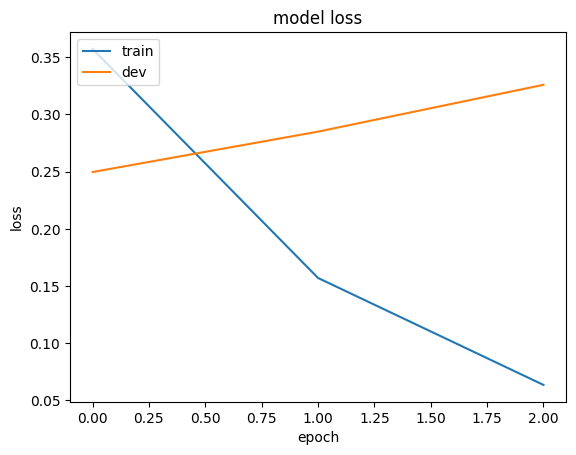

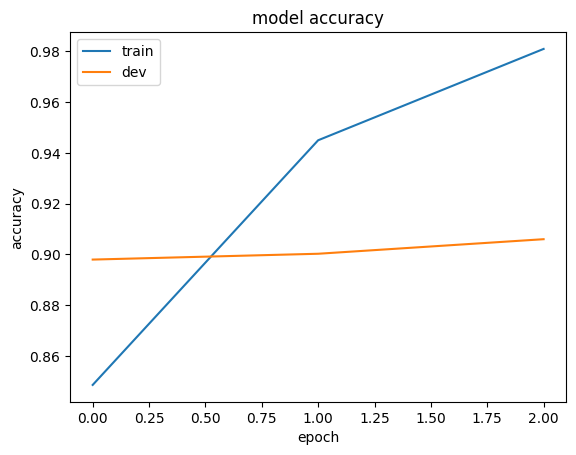

In [15]:
plot_history(history)

A nice feature when fine-tuning a large model is that we do not need to train many epochs (the number of epochs depends on the size of the training set). In this case, it looks like just one epoch can be enough.

Once the model is fine-tuned for sentiment analysis we could evaluate it on the test set.

In [16]:
instance = next(iter(test_loader))
print(instance)

[{'input_ids': tensor([[ 101, 1192, 1169,  ...,    0,    0,    0],
        [ 101,  146, 8223,  ...,    0,    0,    0],
        [ 101, 1135,  112,  ...,    0,    0,    0],
        ...,
        [ 101, 4108, 3820,  ...,    0,    0,    0],
        [ 101, 1370, 1143,  ...,    0,    0,    0],
        [ 101,  142, 1813,  ...,    0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])}, tensor([1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 0, 1, 0, 0, 0])]


In [17]:
test_loss, test_acc = evaluate(model, test_loader)
print('Loss: ', test_loss)
print('Accuracy: ', test_acc)

Loss:  0.35232814918960076
Accuracy:  0.8912685337726524


## 5. Fine-tuning BERT for NLI

Now that you know how to fine-tune BERT model for sentence classification. We could do something similar to fine-tune BERT to Natural Language Inference task. Recall that NLI consist in determining whether a natural language hypothesis can justifiably be inferred from a natural language premise hus given a pair of premise and hypothesis texts, the task is to classify them into three categories: entailment, contradiction, and neutral.

There are many ways to approach the task, but one way is to encode the premise and hypothesis at the same time as shown in the figure below. We separate premise and hypothesis sentences with `[SEP]` and use `[CLS]` token to perform the three-way classification task.


 ![](http://ixa2.si.ehu.es/~jibloleo/uc3m_dl4nlp/img/bert_nli.png)

----



Let's start loading the data for NLI. We'll use the same function used in the previous lab.

In [18]:
import pandas as pd

data = load_dataset("stanfordnlp/snli")
data = data.filter(lambda example: example["label"] != -1)
training_set = pd.DataFrame(data['train'])
dev_set = pd.DataFrame(data['validation'])
test_set = pd.DataFrame(data['test'])

print('Training size: {}'.format(len(training_set)))
print('Dev size: {}'.format(len(dev_set)))
print('Test size: {}'.format(len(test_set)))

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/550152 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/550152 [00:00<?, ? examples/s]

Training size: 549367
Dev size: 9842
Test size: 9824


We are going to reduce the dataset to speed up the experiments in the lab session, but feel free to use the whole dataset after the lab is completed. Fine-tuning with the whole training set can take many hours, so maybe it is a good idea to run just for one or two epochs.


In [19]:
training_set = training_set.head(15000)
dev_set = dev_set.head(2000)

# check if the dataset is still balanced
print('Training labels:')
print(training_set.label.value_counts())

print('Dev labels:')
print(dev_set.label.value_counts())

Training labels:
label
0    5013
2    4995
1    4992
Name: count, dtype: int64
Dev labels:
label
1    677
0    663
2    660
Name: count, dtype: int64


Note that when we load the pretrained model (`from_pretrained`) we need to indicate number of labels that contains the dataset. This can be done with the argument `num_labels`.

In [20]:
from transformers import BertForSequenceClassification, BertTokenizer

nli_model = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=3).to(device)
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


As you can see, the `config` has slightly changed compared to first model. Now it contains the information of the labels (we don't care about the actual id2label mapping for now).

In [21]:
nli_model.config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "dtype": "float32",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.57.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

### Exercise 3:
For the final exercise you have to re-write the function `convert_examples_to_features` so it is able to extract the token ids of premise and hypothesis in one go. Most of the function is already done for you. You just need to fill a small part to complete it.

In [22]:
from transformers import InputFeatures

def convert_nli_examples_to_features(premises, hypotheses, labels):
  labels = list(labels)

  # EXERCISE: Iterate over premises and hypothesis to get tuples of p and h.
  batch_encoding = tokenizer.batch_encode_plus([(p, h) for p, h in zip(premises, hypotheses)],
                                               max_length=128, padding=True, truncation=True)

  features = []
  for i in range(len(premises)):
      inputs = {k: batch_encoding[k][i] for k in batch_encoding}

      feature = InputFeatures(**inputs, label=labels[i])
      features.append(feature)

  for i in range(5):
      print("*** Example ***")
      print("premise: %s" % (premises[i]))
      print("hypothesis: %s" % (hypotheses[i]))
      print("features: %s" % features[i])

  return features

Once you complete the exercise you can convert the dataset to features first, then to a PyTorch `Dataset`, and finally wrap it with a `DataLoader`.

In [23]:
train_features = convert_nli_examples_to_features(training_set.premise, training_set.hypothesis, training_set.label)
train_dataset = convert_features_to_tf_dataset(train_features)

dev_features = convert_nli_examples_to_features(dev_set.premise, dev_set.hypothesis, dev_set.label)
dev_dataset = convert_features_to_tf_dataset(dev_features)

test_features = convert_nli_examples_to_features(test_set.premise, test_set.hypothesis, test_set.label)
test_dataset = convert_features_to_tf_dataset(test_features)

*** Example ***
premise: A person on a horse jumps over a broken down airplane.
hypothesis: A person is training his horse for a competition.
features: InputFeatures(input_ids=[101, 138, 1825, 1113, 170, 3241, 15457, 1166, 170, 3088, 1205, 15478, 119, 102, 138, 1825, 1110, 2013, 1117, 3241, 1111, 170, 2208, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], token_type_ids=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

We use PyTorch `DataLoader` to shuffle the training set and set the batch size. Here we use a batch size of 32; adjust as needed to fit available memory.

In [24]:
# hyperparameters
learning_rate = 3e-5
batch_size = 32
epochs = 3
epsilon = 1e-8

# data loaders
train_loader, dev_loader, test_loader = get_data_loaders(batch_size)

# optimizer
optimizer = torch.optim.Adam(nli_model.parameters(), lr=learning_rate, eps=epsilon)

# execute the train loop
history = train_loop(nli_model, optimizer, epochs)


Epoch 1/3 - Train loss: 0.6772 - Train acc: 0.7129 - Dev loss: 0.5080 - Dev acc: 0.8050 - Time: 253881.50ms
Epoch 2/3 - Train loss: 0.4288 - Train acc: 0.8388 - Dev loss: 0.4987 - Dev acc: 0.8095 - Time: 252833.22ms
Epoch 3/3 - Train loss: 0.2716 - Train acc: 0.9047 - Dev loss: 0.5312 - Dev acc: 0.8145 - Time: 252720.75ms
Total training time: 759.4354610443115


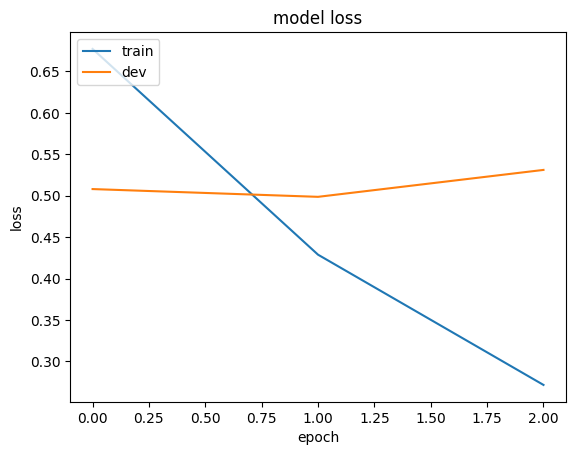

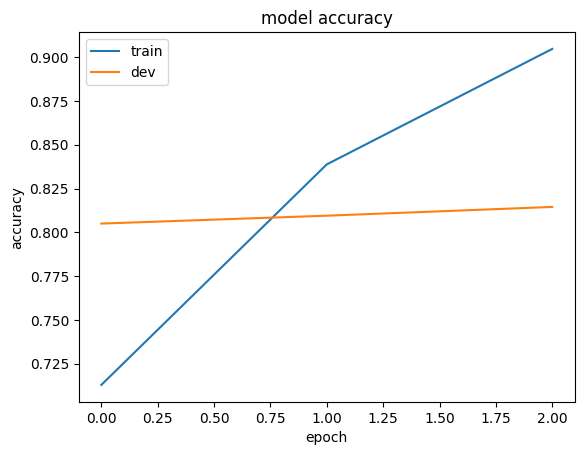

In [25]:
plot_history(history)

As in the previous example, we can process the test set in the same way, and evaluate it directly.

In [26]:
test_loss, test_acc = evaluate(nli_model, test_loader)
print('Loss: ', test_loss)
print('Accuracy: ', test_acc)

Loss:  0.5274705676185968
Accuracy:  0.8211522801302932
